In [2]:
import cupy as cp
import numpy as np
import pandas as pd
import fix_yahoo_finance as yf
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import time

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# 2c. Valor medio esperado de activos

## Desarrollo de la función

### Carga de datos

Estoy bajando los datos de *yahoo finance* manualmente, pero posteriormente sería obtenerlos de la fuente deseada

In [3]:
x = yf.download("AMZN", start='2010-01-01')

[*********************100%***********************]  1 of 1 downloaded


Lo que se descarga es un dataframe. Éste incluye precio de apertura y de cierre, por lo que usaré estas columnas para calcular el rendimiento diario.

In [4]:
x.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,136.250000,136.610001,133.139999,133.899994,133.899994,7599900
2010-01-05,133.429993,135.479996,131.809998,134.690002,134.690002,8851900
2010-01-06,134.600006,134.729996,131.649994,132.250000,132.250000,7178800
2010-01-07,132.009995,132.320007,128.800003,130.000000,130.000000,11030200
2010-01-08,130.559998,133.679993,129.029999,133.520004,133.520004,9830500


<function matplotlib.pyplot.show>

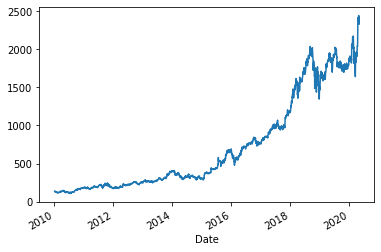

In [5]:
x.Open.plot()
plt.show

### Cálculo de rendimeinto usando *Cupy*
Aquí mandamos los datos a *cupy*

In [0]:
x_o = cp.asarray(x.Open)
#x_f = cp.asarray(x.Close)
x_f = x_o[1:]

El cálculo de los rendimientos diarios usando *cupy*:

In [0]:
r = cp.log(x_f/x_o[:-1])

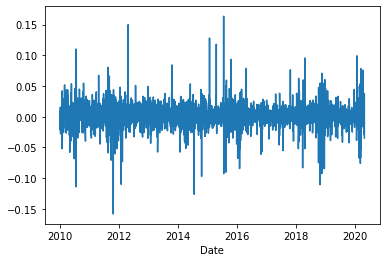

In [8]:
sns.lineplot(x=x.index[:-1], y=cp.asnumpy(r))
plt.show()

El rendimiento estimado $\hat{r}$ está dado por

In [0]:
r_est = r.mean()

In [10]:
r_est

array(0.00109352)

In [11]:
print('La tasa anual sería de {}'.format(np.exp(260*r_est)-1))

La tasa anual sería de 0.3288501047648471


In [12]:
0.00109352*260

0.2843152

## Funciones

In [0]:
def calcular_rendimiento_vector(x):
  """
  Función para calcular el rendimiento esperado

  params:
      x     vector de precios
  
  return:
      r_est rendimiento esperado diario
  """

  # Definimos precios iniciales y finales como arreglo alojado en la gpu
  x_o = cp.asarray(x)
  x_f = x_o[1:]

  # Calculamos los rendimientos diarios
  r = cp.log(x_f/x_o[:-1])

  return r



In [0]:
def calcular_rendimiento(X):
  """
  Función para calcular el rendimiento esperado para un conjunto de acciones

  params:
      X      matriz mxn de precios, donde:
             m es el número de observaciones y
             n el número de acciones
  
  return:
      r_est rvector de rendimientos esperados
  """
  m,n = X.shape
  r_est = cp.zeros(n)

  for i in range(n):
    r_est[i] = calcular_rendimiento_vector(X[:,i]).mean()

  return 264*r_est



## Implementación

Abajo hago una pequeña prueba con las "trending stocks" de yahoo. La intención no es utilizar esta información, solo una pequeña prueba de la función

In [0]:
acciones = ['AMZN','WDC','CLX','AAPL','SGEN','WY','INO','LRCX','AKRX','ASGN','NWL','X','RTX','XOM','^GSPC']

In [16]:
df = yf.download('AMZN', start='2010-01-01').Open
for a in acciones[1:]:
  x = yf.download(a, start='2010-01-01').Open
  df = pd.concat([df,x], axis=1)
  

[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*******************

In [0]:
df.columns=acciones

In [18]:
df.head()

,AMZN,WDC,CLX,AAPL,SGEN,WY,INO,LRCX,AKRX,ASGN,NWL,X,RTX,XOM,^GSPC
Date,,,,,,,,,,,,,,,
2010-01-04,136.250000,44.400002,61.549999,30.490000,10.24,43.889999,4.20,39.700001,1.82,7.33,15.12,56.419998,44.185020,68.720001,1116.560059
2010-01-05,133.429993,45.349998,61.270000,30.657143,10.55,44.290001,4.56,39.790001,1.87,7.40,15.27,58.070000,45.084961,69.190002,1132.660034
2010-01-06,134.600006,46.540001,61.770000,30.625713,10.56,44.320000,4.64,39.630001,1.81,7.19,15.05,57.919998,44.405285,69.449997,1135.709961
2010-01-07,132.009995,46.400002,61.709999,30.250000,10.85,44.540001,4.52,39.250000,1.78,7.03,15.54,60.240002,44.059158,69.900002,1136.270020
2010-01-08,130.559998,45.490002,61.130001,30.042856,10.75,44.250000,4.72,39.330002,1.70,7.36,15.70,60.840000,44.216488,69.690002,1140.520020


In [0]:
X = df.to_numpy()

In [29]:
toc = time.time()
R = calcular_rendimiento(X)
tic = time.time()
print("El tiempo fue de: {} segundos".format(tic-toc))

El tiempo fue de: 0.007699728012084961 segundos


In [30]:
R

array([ 0.3288501 , -0.00915513,  0.1211198 ,  0.25111211,  0.2999772 ,
       -0.07710446,  0.10110929,  0.20053181, -0.18011359,  0.21237055,
       -0.01349351, -0.18378496,  0.03694549, -0.04013559,  0.09901085])

# 2b. Matriz de varianzas y covarianzas



In [0]:
def calcular_varianza(X):

  """
  Función para calcular el la matriz de varianzas y covarianzas para un conjunto de acciones

  params:
      X      matriz mxn de precios, donde:
             m es el número de observaciones y
               n el número de acciones
  
  return:
      S  matriz de varianzas y covarianzas
  """
  m,n=X.shape
  X = cp.asarray(X)

  X_m = cp.zeros((m-1,n))

  for i in range(n):
    X_m[:,i] = calcular_rendimiento_vector(X[:,i]) - calcular_rendimiento_vector(X[:,i]).mean()

  S = (cp.transpose(X_m)@X_m)/(m-2)

  return S




In [32]:
tic=time.time()
temp = calcular_varianza(X)
toc = time.time()
print("El tiempo fue de: {} segundos".format(toc-tic))

El tiempo fue de: 2.10793399810791 segundos


In [33]:
type(temp)

cupy.core.core.ndarray

In [34]:
temp

array([[4.12359663e-04, 1.81729879e-04, 4.13009284e-05, 1.68877325e-04,
        1.83704222e-04, 1.06090665e-04, 1.19672300e-04, 1.70895807e-04,
        1.22011973e-04, 1.63445244e-04, 1.37569656e-04, 2.04226429e-04,
        1.17617159e-04, 9.22134371e-05, 8.91431260e-05],
       [1.81729879e-04, 7.08102131e-04, 3.48825448e-05, 1.85900217e-04,
        1.93457898e-04, 2.00037488e-04, 1.34727931e-04, 2.93985833e-04,
        2.04203601e-04, 2.26546977e-04, 1.82564118e-04, 3.62314977e-04,
        1.83944808e-04, 1.45858168e-04, 1.16636565e-04],
       [4.13009284e-05, 3.48825448e-05, 1.30230541e-04, 3.73429153e-05,
        4.50188993e-05, 5.41233591e-05, 6.22039764e-06, 3.51684928e-05,
        2.02790451e-05, 4.56505648e-05, 5.73091762e-05, 5.14664745e-05,
        3.88638111e-05, 3.43763865e-05, 2.77547622e-05],
       [1.68877325e-04, 1.85900217e-04, 3.73429153e-05, 3.27799077e-04,
        1.46228378e-04, 1.24556975e-04, 1.07910343e-04, 1.70875477e-04,
        1.23551781e-04, 1.42815763e-0

In [0]:
m,n =X.shape

In [38]:
tic=time.time()
temp = cp.zeros((m-1,n))

for i in range(n):
  temp[:,i] = calcular_rendimiento_vector(X[:,i])

temp=np.cov(temp, rowvar=False)
toc = time.time()
print("El tiempo fue de: {} segundos".format(toc-tic))

El tiempo fue de: 0.7314815521240234 segundos


In [39]:
temp

array([[4.12359663e-04, 1.81729879e-04, 4.13009284e-05, 1.68877325e-04,
        1.83704222e-04, 1.06090665e-04, 1.19672300e-04, 1.70895807e-04,
        1.22011973e-04, 1.63445244e-04, 1.37569656e-04, 2.04226429e-04,
        1.17617159e-04, 9.22134371e-05, 8.91431260e-05],
       [1.81729879e-04, 7.08102131e-04, 3.48825448e-05, 1.85900217e-04,
        1.93457898e-04, 2.00037488e-04, 1.34727931e-04, 2.93985833e-04,
        2.04203601e-04, 2.26546977e-04, 1.82564118e-04, 3.62314977e-04,
        1.83944808e-04, 1.45858168e-04, 1.16636565e-04],
       [4.13009284e-05, 3.48825448e-05, 1.30230541e-04, 3.73429153e-05,
        4.50188993e-05, 5.41233591e-05, 6.22039764e-06, 3.51684928e-05,
        2.02790451e-05, 4.56505648e-05, 5.73091762e-05, 5.14664745e-05,
        3.88638111e-05, 3.43763865e-05, 2.77547622e-05],
       [1.68877325e-04, 1.85900217e-04, 3.73429153e-05, 3.27799077e-04,
        1.46228378e-04, 1.24556975e-04, 1.07910343e-04, 1.70875477e-04,
        1.23551781e-04, 1.42815763e-0